---
**Author:** Arifa Kokab  
**For:** AAI-540 Machine Learning Operations  
**Institution:** University of San Diego

# Batch Inference with SageMaker Batch Transform

## Introduction

This notebook demonstrates how to perform batch inference on a set of extracted video frames using an already registered and deployed facial expression analysis model in AWS SageMaker. Batch Transform enables large-scale, asynchronous prediction, supporting scalable and efficient emotion recognition across video data.

---

## 1. Setup: Import Libraries and Initialize SageMaker Session

This section imports the necessary SageMaker and AWS libraries, sets up the execution role and session, and defines input/output S3 locations for the batch job.

In [1]:
from sagemaker import get_execution_role, Session
from sagemaker.transformer import Transformer
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import boto3
import json
import os

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [2]:
model_name = 'FacialExpressionAnalysisFinal'
input_location = 's3://sagemaker-us-east-1-301806113644/batch_input/'   # Folder with input frames
output_location = 's3://sagemaker-us-east-1-301806113644/batch_output/' # Folder for results

role = get_execution_role()
sagemaker_session = Session()

## 2. Launch Batch Transform Job

We create and configure a SageMaker `Transformer` to process all input frames in batch mode, saving the predicted emotion results to S3. This approach scales well for high-throughput inference workloads.

In [3]:
# Create the transformer
transformer = Transformer(
    model_name=model_name,
    instance_count=1,
    instance_type='ml.m5.large',
    output_path=output_location,
    assemble_with='Line',
    accept='application/json'
)

In [4]:
# Start the batch transform job
transformer.transform(
    data=input_location,
    content_type='application/x-image',
    split_type='None'
)

# Wait for the job to complete
transformer.wait()
print("✓ Batch Transform completed.")

INFO:sagemaker:Creating transform job with name: pytorch-inference-2025-06-26-08-18-43-515


.................................Requirement already satisfied: torch in /opt/conda/lib/python3.8/site-packages (from -r /opt/ml/model/code/requirements.txt (line 1)) (1.9.1)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 63.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.4/515.4 kB 47.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 45.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 92.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 27.1 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 20.4
    Uninstalling packaging-20.4:
      Successfully uninstalled packaging-20.4
[notice] A new release of pip available: 22.2.2 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
2025-06-26T08:24:21,208 [INFO ] main org.pytorch.serve.servingsdk.impl.Pl

## 3. View and Download Batch Transform Outputs

After the batch job completes, we list and download the output prediction files from S3. Each `.out` file contains the model’s predicted probabilities for a single frame.

In [5]:
#View the Output
bucket = 'sagemaker-us-east-1-301806113644'
prefix = 'batch_output/'

s3 = boto3.client('s3')
response = s3.list_objects_v2(Bucket=bucket, Prefix=prefix)
for obj in response.get('Contents', []):
    print(obj['Key'])

batch_output/
batch_output/frame_0000.jpg.out
batch_output/frame_0001.jpg.out
batch_output/frame_0002.jpg.out
batch_output/frame_0003.jpg.out
batch_output/frame_0004.jpg.out
batch_output/frame_0005.jpg.out
batch_output/frame_0006.jpg.out
batch_output/frame_0007.jpg.out
batch_output/frame_0008.jpg.out
batch_output/frame_0009.jpg.out
batch_output/frame_0010.jpg.out
batch_output/frame_0011.jpg.out
batch_output/frame_0012.jpg.out
batch_output/frame_0013.jpg.out
batch_output/frame_0014.jpg.out
batch_output/frame_0015.jpg.out
batch_output/frame_0016.jpg.out
batch_output/frame_0017.jpg.out
batch_output/frame_0018.jpg.out
batch_output/frame_0019.jpg.out
batch_output/frame_0020.jpg.out
batch_output/frame_0021.jpg.out


In [6]:
bucket = 'sagemaker-us-east-1-301806113644'
prefix = 'batch_output/'
local_folder = './batch_output/'

os.makedirs(local_folder, exist_ok=True)
s3 = boto3.client('s3')

# List all .out files
response = s3.list_objects_v2(Bucket=bucket, Prefix=prefix)
for obj in response['Contents']:
    key = obj['Key']
    if key.endswith('.out'):
        local_path = os.path.join(local_folder, os.path.basename(key))
        s3.download_file(bucket, key, local_path)

## 4. Post-processing: Parse Batch Predictions

We parse each output file to determine the predicted emotion label per frame, creating a structured results DataFrame for further analysis or reporting.

In [7]:
emotion_labels = ['Neutral', 'Happiness', 'Surprise', 'Sadness', 'Anger', 'Disgust', 'Fear', 'Contempt']

results = []
for fname in sorted(os.listdir(local_folder)):
    if fname.endswith('.out'):
        with open(os.path.join(local_folder, fname), 'r') as f:
            preds = json.loads(f.read())
            max_idx = int(np.argmax(preds))
            label = emotion_labels[max_idx]
            results.append({
                'frame': fname.replace('.jpg.out', ''),
                'emotion': label,
                'probabilities': preds
            })

df = pd.DataFrame(results)
print(df[['frame', 'emotion']])

         frame  emotion
0   frame_0000  Disgust
1   frame_0001    Anger
2   frame_0002  Disgust
3   frame_0003    Anger
4   frame_0004  Disgust
5   frame_0005  Disgust
6   frame_0006  Disgust
7   frame_0007  Disgust
8   frame_0008  Disgust
9   frame_0009  Disgust
10  frame_0010  Disgust
11  frame_0011  Disgust
12  frame_0012  Disgust
13  frame_0013  Disgust
14  frame_0014  Disgust
15  frame_0015  Disgust
16  frame_0016  Disgust
17  frame_0017    Anger
18  frame_0018  Disgust
19  frame_0019  Disgust
20  frame_0020  Disgust
21  frame_0021    Anger


## 5. Visualization: Plot Emotions Over Time

We visualize the emotion predictions for each video frame, helping to identify patterns or emotional shifts over time.

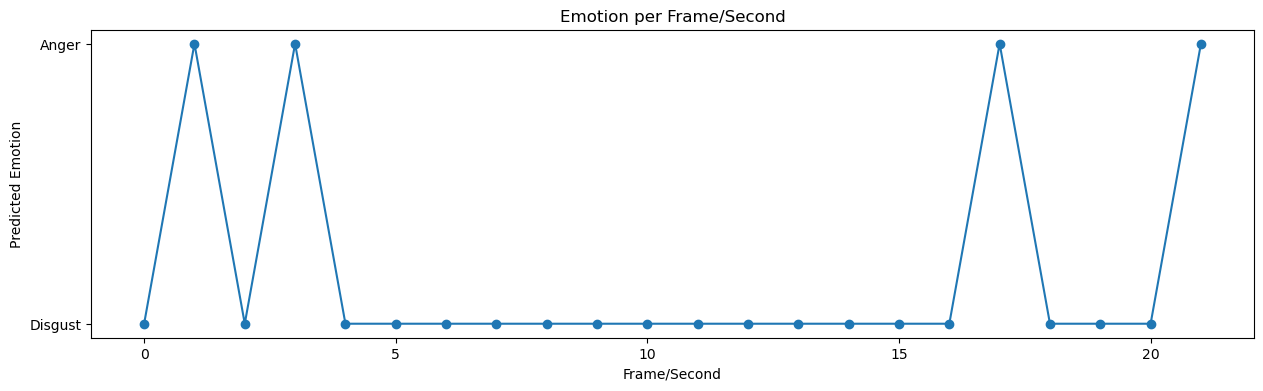

In [8]:
df['second'] = df['frame'].str.extract(r'(\d+)').astype(int)

plt.figure(figsize=(15,4))
plt.plot(df['second'], df['emotion'], marker='o')
plt.xlabel('Frame/Second')
plt.ylabel('Predicted Emotion')
plt.title('Emotion per Frame/Second')
plt.show()

## Conclusion

This notebook demonstrates a complete workflow for performing large-scale batch inference using AWS SageMaker Batch Transform, parsing the results, and visualizing emotion recognition outcomes over time. This approach enables scalable, automated post-processing for video-based machine learning pipelines.